In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b2cb70414bc23120cb6b2c56299c3d4d546716b2ea8997041709d9470cc366e5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
#reference                           #https://keep-steady.tistory.com/35

In [ ]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [ ]:
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=50)

224


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
## 데이타 로드!!
batch_size  = 128
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

#google drive 연동
from google.colab import drive
drive.mount('/content/drive')


## make dataset
from torchvision import transforms, datasets
data_path = "/content/drive/MyDrive/data/computer_vision_task/train" # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
president_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/data/computer_vision_task/test" # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
tests_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

In [ ]:
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(president_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(president_dataset, train_idx)
tmp_dataset       = Subset(president_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)


In [ ]:

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 4 / 1 / 1


In [ ]:
# ## 데이타 체크
# import torchvision
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

# num_show_img = 5

# class_names = {}
# for cls_num in range(50): 
#   class_names[str(cls_num)] = str(cls_num)
 

# # train check
# inputs, classes = next(iter(dataloaders['train']))
# out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
# imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# # valid check
# inputs, classes = next(iter(dataloaders['valid']))
# out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
# imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# # test check
# inputs, classes = next(iter(dataloaders['test']))
# out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
# imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {}
for cls_num in range(50): 
  class_names[str(cls_num)] = str(cls_num)
 

# train check
inputs, classes = next(iter(dataloaders['train']))
out1 = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
#imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out2 = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
#imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out3 = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
#imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
imshow(out1, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
#imshow(out2, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
#imshow(out3, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
import math

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #torch.max(outputs, 2) IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)
                    print("checking process in train models!! ___________________ outpusts : ", outputs, " length of outputs!! : ", len(outputs), " shape of outputs!!! : ", outputs.shape) 
                    #outputs는 현재 형태는 batch size X label(50)

                    print("checking process in train models!! ___________________ preds : ", preds, " shape of preds : ", preds.shape)
                    #preds는 128개 배치에 대한 예측값 128개
                    
                    #torch.max는 shape는 일단 없넹
                    #tormax = torch.max(outputs, 1)
                    #rint("checking process in train models!! ___________________ torch.max(outputs, 1) : ", tormax ," length of torch.max : ", len(tormax ) )
                    
                    false_list, preds_list = torch.sort(outputs,  descending=True)  #/** additional part **/#

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #기존: 
                #running_corrects += torch.sum(preds == labels.data) 
                #num_cnt += len(labels)

                #dcg 적용: 아래 #----------------------------------------------------------------------------
                #topKval = 3 #test로 top3로
                topKval = 5 #test로 top5로
                for iii in range(topKval):
                  indices = torch.tensor([ iii ], device="cuda:0")
                  predTopK = torch.index_select(preds_list, 1, indices)
                  predTopK = torch.reshape( predTopK, (-1, ) )

                  print("iii is %d      divison by zero???  : "%(iii), math.log(2, iii+2 ) )
                  
                  #running_corrects += torch.sum(   (predTopK == labels.data) / math.log(2, iii+2 )   ) # DCG 적용
                  running_corrects += torch.sum(   (predTopK == labels.data) /  (iii+1)    ) # MAP@K 적용
                  
                num_cnt += len(labels)
                #dcg 적용: 위 #----------------------------------------------------------------------------
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                torch.save(model.state_dict(),"drive/MyDrive/model/image_class/image_model_210114_1.pt")
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #torch.save(model.state_dict(), "/content/drive/MyDrive/model/image_class/president_model.pt")
    torch.save(model.state_dict(),"drive/MyDrive/model/image_class/image_model_210114_1.pt")
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
#-------------------------------아래 쫙 torch 형태 테스트---------------------------------_#

In [ ]:
b = torch.randn(3)
print(b)

b2 = b
c = torch.rand(3)
print(b2)
print(c)

tensor([2.6101, 1.5238, 0.8179])
tensor([2.6101, 1.5238, 0.8179])
tensor([0.3368, 0.9035, 0.9918])


In [ ]:
d = torch.tensor([     [0,0,2.6101], [0,1.5238,0], [0.8179,0,0]               ]  )
print(d)

tensor([[0.0000, 0.0000, 2.6101],
        [0.0000, 1.5238, 0.0000],
        [0.8179, 0.0000, 0.0000]])


In [ ]:
a = torch.randn(1, 3)
print(a)



tensor([[0.2976, 0.9933, 0.5625]])


In [ ]:
print(torch.max(a) )
print("'''''''''''''''''''''''''''''''''''''''''")
print(torch.max(a, 1) )

print("-----------==================-------------")

print( torch.sort(a, descending=True) )

tensor(0.9933)
'''''''''''''''''''''''''''''''''''''''''
torch.return_types.max(
values=tensor([0.9933]),
indices=tensor([1]))
-----------==================-------------
torch.return_types.sort(
values=tensor([[0.9933, 0.5625, 0.2976]]),
indices=tensor([[1, 2, 0]]))


In [ ]:
x = torch.randn(3, 4)
print(x)

tensor([[ 0.3985,  1.0277,  0.3146, -0.3213],
        [ 0.6226, -0.4492,  0.6144,  1.0075],
        [ 1.9314,  1.8235,  0.0220,  0.5228]])


In [ ]:
print(x)

tensor([[ 0.3985,  1.0277,  0.3146, -0.3213],
        [ 0.6226, -0.4492,  0.6144,  1.0075],
        [ 1.9314,  1.8235,  0.0220,  0.5228]])


In [ ]:
print(torch.max(x, 1))

torch.return_types.max(
values=tensor([1.0277, 1.0075, 1.9314]),
indices=tensor([1, 3, 0]))


In [ ]:
aaa, bbb = torch.max(x, 1)
print(aaa)
print("========")
print(bbb)

tensor([1.0277, 1.0075, 1.9314])
tensor([1, 3, 0])


In [ ]:
x_sorted = torch.sort(x, descending=True)
print(x_sorted)
valval, indind = torch.sort(x, descending=True)
print(indind)

print("-----------------")
indices = torch.tensor([0])
indind2 = torch.index_select(indind, 1, indices)
print( indind2 )

print("=================")
print( torch.reshape( indind2, (-1, )) )

torch.return_types.sort(
values=tensor([[ 1.0277,  0.3985,  0.3146, -0.3213],
        [ 1.0075,  0.6226,  0.6144, -0.4492],
        [ 1.9314,  1.8235,  0.5228,  0.0220]]),
indices=tensor([[1, 0, 2, 3],
        [3, 0, 2, 1],
        [0, 1, 3, 2]]))
tensor([[1, 0, 2, 3],
        [3, 0, 2, 1],
        [0, 1, 3, 2]])
-----------------
tensor([[1],
        [3],
        [0]])
tensor([1, 3, 0])


In [ ]:
_, _x = torch.max(x, 1)
print( x )

tensor([[ 0.3985,  1.0277,  0.3146, -0.3213],
        [ 0.6226, -0.4492,  0.6144,  1.0075],
        [ 1.9314,  1.8235,  0.0220,  0.5228]])


In [ ]:
indices = torch.tensor([1, 2])
print( torch.index_select(x, 1, indices) )

tensor([[ 1.0277,  0.3146],
        [-0.4492,  0.6144],
        [ 1.8235,  0.0220]])


In [ ]:
print( '1' in ['1',2])

True


In [ ]:
# torch.save(model.state_dict(),"drive/MyDrive/model/image_class/model.pt")

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/model/image_class/president_model.pt")

In [ ]:
#왜인지 에러가 나서..
device = torch.device("cuda:0")        #("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=400) 
#torch.save(model.state_dict(),"drive/MyDrive/model/image_class/image_model_210110.pt")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
         -9.9006e-02, -1.1735e+00,  9.8145e+00, -1.6163e+00,  8.7189e-01,
          2.9891e-01,  2.6770e+00,  1.4307e+00, -1.7364e+00, -4.9709e-01,
         -5.7856e-01, -1.8622e+00, -6.3784e-01, -5.3142e-01, -1.8507e+00,
         -1.5862e+00,  6.0231e-01,  1.0152e-01, -2.5244e+00, -2.5960e+00,
         -2.8232e+00, -2.7962e-01, -9.3234e-01,  2.5114e+00, -1.2830e+00,
         -1.4625e+00,  8.9957e-01,  2.8753e+00, -5.2554e-01, -3.9312e-01,
         -3.6028e-01, -9.4621e-01,  7.2604e-01, -1.3134e+00,  1.7702e+00,
          2.4868e+00,  1.3857e+00,  1.0128e+00,  1.7518e-01, -4.6425e-01,
          1.4405e+00,  1.1395e+00, -1.5109e+00,  2.2407e-01,  4.8384e-01],
        [-3.6090e+00,  2.5116e+00, -1.6759e+00, -1.1448e-01,  2.3201e-01,
         -2.7117e-01, -1.3284e+00, -2.6166e+00,  5.2167e+00, -1.0913e+00,
         -8.3567e-01, -5.4246e-01, -2.0901e+00,  1.1738e+01, -4.8454e-03,
          2.2566e+00,  5.2934e-01, -1.0784e+00, -7.4098e-02,  8.7589e-01,
 

In [ ]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt, running_corrects_topK, num_cnt_topK, running_corrects_topK_forMAP = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            false_list, preds_list = torch.sort(outputs,  descending=True)  #/** additional part **/#

            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)

            #dcg 적용: 아래 #----------------------------------------------------------------------------
            topKval = 5 #test로 top3로
            for iii in range(topKval):
              indices = torch.tensor([ iii ], device="cuda:0")
              predTopK = torch.index_select(preds_list, 1, indices)
              predTopK = torch.reshape( predTopK, (-1, ) )

              #print("iii is %d      divison by zero???  : "%(iii), math.log(2, iii+2 ) )
              print( "iii is %d     다음 값은 사실 1을 넘으면 안 됨 :: %2f"%(iii, ( (predTopK == labels.data) / math.log(2, iii+2 )     ) )  )
              running_corrects_topK += torch.sum(   (predTopK == labels.data) / math.log(2, iii+2 )   )
              running_corrects_topK_forMAP += torch.sum(   (predTopK == labels.data) / ( iii+1 )   )

              #print(" running_corrects_topK : ", running_corrects_topK, " num_cnt_topK :", num_cnt_topK)
              
              num_cnt_topK += len(labels)
            #dcg 적용: 위 #----------------------------------------------------------------------------

            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        dcg_mean = running_corrects_topK / num_cnt #/ ** additional part ** /#
        mapK = running_corrects_topK_forMAP / num_cnt
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))
        print(' dcg_mean : %.2f' %(dcg_mean) )
        print(' MAP@K    : %.2f' %(mapK))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    # model.train(mode=was_training);  # 다시 train모드로
    
    

In [ ]:
## TEST!
test_and_visualize_model(model, phase = 'test') #test done : loss/acc : 2.17 / 46.0

In [ ]:
datasets['real_test'] = tests_dataset

dataloaders['real_test'] = torch.utils.data.DataLoader(datasets['real_test'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)

batch_num['real_test'] = len(dataloaders['real_test'])

iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345

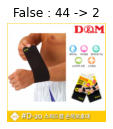

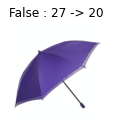

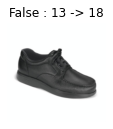

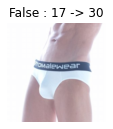

In [ ]:
## TEST!
test_and_visualize_model(model, phase = 'real_test')  

In [ ]:
## TEST!

model.load_state_dict(torch.load(  "/content/drive/MyDrive/model/image_class/complete/image_model_210113_1.pt" ))

test_and_visualize_model(model, phase = 'real_test')  ##image_model_220110_2.pt (from 210110)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

 running_corrects_topK :  tensor(67., device='cuda:0')  num_cnt_topK : 0.0
 running_corrects_topK :  tensor(103.4541, device='cuda:0')  num_cnt_topK : 128.0
 running_corrects_topK :  tensor(119.4541, device='cuda:0')  num_cnt_topK : 256.0
 running_corrects_topK :  tensor(131.0638, device='cuda:0')  num_cnt_topK : 384.0
 running_corrects_topK :  tensor(143.9886, device='cuda:0')  num_cnt_topK : 512.0
 running_corrects_topK :  tensor(225.9886, device='cuda:0')  num_cnt_topK : 640.0
 running_corrects_topK :  tensor(249.7630, device='cuda:0')  num_cnt_topK : 768.0
 running_corrects_topK :  tensor(265.7630, device='cuda:0')  num_cnt_topK : 896.0
 running_corrects_topK :  tensor(277.3727, device='cuda:0')  num_cnt_topK : 1024.0
 running_corrects_topK :  tensor(285.1276, device='cuda:0')  num_cnt_topK : 1152.0
 running_corrects_topK :  tensor(369.1276, device='cuda:0')  num_cnt_topK : 1280.0
 running_corrects_topK :  tensor(392.9020, device='cuda:0')  num_cnt_topK : 1408.0
 running_corrects_t

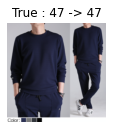

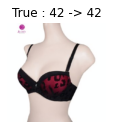

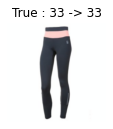

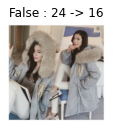

In [ ]:
## TEST!

model.load_state_dict(torch.load(  "/content/drive/MyDrive/model/image_class/complete/president_model.pt" ))

test_and_visualize_model(model, phase = 'real_test')  ##image_model_220110_2.pt (from 210110)

In [ ]:
#재학습
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=400) 
#torch.save(model.state_dict(),"drive/MyDrive/model/image_class/image_model_210110.pt")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
         7, 42, 38, 26, 33,  6, 30, 27,  5, 28, 33, 43, 35, 27, 45, 11, 49, 27,
        27,  4], device='cuda:0')  shape of preds :  torch.Size([128])
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
checking process in train models!! ___________________ outpusts :  tensor([[-1.7633e+00, -1.2239e+00, -1.4043e+00, -2.5252e+00,  5.8487e-01,
         -7.0474e-01, -2.0754e-01,  2.0460e+00, -2.2712e+00,  4.2152e-01,
         -2.3991e+00,  2.6536e+00, -1.0612e+00, -9.9492e-01,  1.8812e+00,
          1.7958e-01, -3.8193e-01,  2.6647e-01, -7.5460e-02, -9.4643e-01,
         -1.9278e+00,  7.9365e-01,  1.6279e+00, -4.1953e+00,  4.8729e-01,
          1.7374e-01,  5.2647e-01,  7.5811e-02, -3.0781e-01,  3.6146e+00,
         -9.2465e-01, -7.0978e-01,  9.5879e+00,  1.

iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345416
iii is 0      divison by zero???  :  1.0
iii is 1      divison by zero???  :  0.6309297535714574
iii is 2      divison by zero???  :  0.5
iii is 3      divison by zero???  :  0.43067655807339306
iii is 4      divison by zero???  :  0.3868528072345

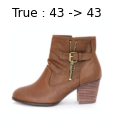

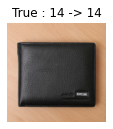

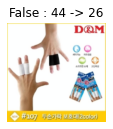

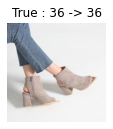

In [ ]:
## TEST!
test_and_visualize_model(model, phase = 'real_test') 

In [ ]:
model.load_state_dict(torch.load(  "/content/drive/MyDrive/model/image_class/president_model.pt" ))

<All keys matched successfully>

In [ ]:
## TEST!
test_and_visualize_model(model, phase = 'real_test')  ##president_model (from 210109) #test done : loss/acc : 1.46 / 60.4

In [ ]:
## TEST!

model.load_state_dict(torch.load(  "/content/drive/MyDrive/model/image_class/complete/image_model.pt" ))

test_and_visualize_model(model, phase = 'real_test')  ##image_model (from 210109)



# test done : loss/acc : 1.44 / 60.9
#  dcg_mean : 1.13
#  MAP@K    : 0.72

In [ ]:
## TEST!
test_and_visualize_model(model, phase = 'real_test')  ##image_model_210110 #test done : loss/acc : 1.55 / 57.8

In [ ]:
torch.save(model.state_dict(),"drive/MyDrive/model/image_class/image_model.pt")